In [54]:
def link2res(df,column_name):
    route = [('A','2',[110,123,107,108,120,117]),\
             ('A','3',[110,123,107,108,119,114,118,122]),\
             ('B','1',[105,100,111,103,116,101,121,106,113]),\
             ('B','3',[105,100,111,103,122]),\
             ('C','1',[115,102,109,104,112,111,103,116,101,121,106,113]),\
             ('C','3',[115,102,109,104,112,111,103,122])]
    column_names = ['intersection_id','tollgate_id','time_window','pred'] # 前三个keys,pred是计算的值
    res = pd.DataFrame(columns = column_names)

    def getTimeWindow(start_time):
        time = pd.to_datetime(start_time)
        return '['+str(time)+','+str(time + pd.Timedelta(minutes=20))+')'

    for i_id,t_id,link_seq in route:
        # y 为predict_time
        rdf = df[df['link'].isin(link_seq)].groupby(['start_time'])[column_name].sum()
        rdf = pd.DataFrame({'intersection_id':i_id,'tollgate_id':t_id,'start_time':rdf.index,'pred':rdf.values})
        rdf['time_window'] = rdf['start_time'].map(lambda x:getTimeWindow(x))
        res = res.append(rdf[['intersection_id','tollgate_id','time_window','pred']])
    return res

def res2MAPE(result,column_name):
    #读取ground_truth
    ground_truth = pd.read_csv('phase1_training/20min_avg_travel_time_training_phase1.csv')
    res_df = link2res(result,column_name)
    #merge 3 keys
    res_df['tollgate_id'] = res_df['tollgate_id'].astype(int)
    ground_truth['tollgate_id'] = ground_truth['tollgate_id'].astype(int)
    merged = pd.merge(res_df,ground_truth,on= ['intersection_id','tollgate_id','time_window'],how='left')
    #删除ground_truth都没有的行
    merged = merged.dropna(axis=0,how='any')
    return merged.apply(lambda x: abs(x['avg_travel_time'] - x['pred'])/ x['avg_travel_time'], axis=1).mean()

In [55]:
import pandas as pd
import numpy as np

def remove_not_in_target_20min(data):
    data['start_time_20min']=pd.to_datetime(data['start_time']).dt.time.map(str)
    ind1 = (data.start_time_20min>='08:00:00')&(data.start_time_20min<='10:00:00')
    ind2 = (data.start_time_20min>='17:00:00')&(data.start_time_20min<='19:00:00')
    res_data = data[ind1|ind2].drop(['start_time_20min'],axis=1)
    return res_data

def split_by_data(data):
    last_day_train = '2016-09-31'
    first_day_test = '2016-10-11' #除去国庆七天
    data['date']=pd.to_datetime(data['start_time']).dt.date
    test_data=data[data['date']>=pd.to_datetime(first_day_test)]
    train_data=data[data['date']<=pd.to_datetime(first_day_test)]
    test_data=test_data.drop(['date','link_time'],axis=1).reset_index(drop=True)
    train_data=train_data.drop(['date','link_time'],axis=1).reset_index(drop=True)
    return train_data,test_data

input_file = './phase1_training/train_data_0413.csv'
#input_file = 'rolling_data1.csv'
data = pd.read_csv(input_file)
train_data,test_data = split_by_data(remove_not_in_target_20min(data))

submistest_file = './phase1_test/submit_test_tesk1_0413.csv'
submistest = pd.read_csv(submistest_file)

In [56]:
result = test_data[['link','start_time','y','linktime_mean']]
result_train = train_data[['link','start_time','y','linktime_mean']]


In [57]:
train_data.columns ,submistest.columns

(Index(['link', 'start_time', 'y', 'is_workday', 'is_holiday', 'leg',
        'linktime_mean_2h', 'linktime_median_2h', 'linktime_mean_1h',
        'linktime_mean', 'linktime_median', 'linktime_var',
        'linktime_quantile25', 'linktime_quantile75', 'pressure', 'wind_speed',
        'temperature', 'rel_humidity', 'precipitation', 'wind_direction2',
        'wind_speed2', 'precipitation2', 'SSD', 'SSD_level', 'length', 'lanes',
        'weekday_crowd_degree', 'hour_crowd_degree'],
       dtype='object'),
 Index(['link', 'start_time', 'y', 'is_workday', 'is_holiday', 'leg',
        'linktime_mean_2h', 'linktime_median_2h', 'linktime_mean_1h',
        'link_time', 'linktime_mean', 'linktime_median', 'linktime_var',
        'linktime_quantile25', 'linktime_quantile75', 'pressure', 'wind_speed',
        'temperature', 'rel_humidity', 'precipitation', 'wind_direction2',
        'wind_speed2', 'precipitation2', 'SSD', 'SSD_level', 'length', 'lanes',
        'weekday_crowd_degree', 'hour_c

In [5]:
train_data.isnull().any()

link                    False
start_time              False
y                       False
is_workday              False
is_holiday              False
leg                     False
linktime_mean_2h        False
linktime_median_2h      False
linktime_mean_1h        False
linktime_mean           False
linktime_median         False
linktime_var            False
linktime_quantile25     False
linktime_quantile75     False
pressure                False
wind_speed              False
temperature             False
rel_humidity            False
precipitation           False
wind_direction2         False
wind_speed2             False
precipitation2          False
SSD                     False
SSD_level               False
length                  False
lanes                   False
weekday_crowd_degree    False
hour_crowd_degree       False
dtype: bool

In [58]:
choice = ['is_workday', 'is_holiday', 'leg',\
       'linktime_mean_2h', 'linktime_median_2h', 'linktime_mean_1h',\
       'linktime_mean', 'linktime_median', 'linktime_var',\
       'linktime_quantile25', 'linktime_quantile75', 'pressure', 'wind_speed',\
       'temperature', 'rel_humidity', 'precipitation', 'wind_direction2',\
       'wind_speed2', 'precipitation2', 'SSD', 'SSD_level', 'length', 'lanes',\
       'weekday_crowd_degree', 'hour_crowd_degree']

In [7]:
# 没有onehot
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

def get_x_y(data):
    global choice
    #data = np.array(data)
    X = np.array(data[choice])
    Y = np.array(data)[:,2]
    return X,Y
x_train,y_train = get_x_y(train_data)
x_test,y_test = get_x_y(test_data)

x_submission,y_submission = get_x_y(submistest)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_submission.shape,y_submission.shape)
print(y_submission)

x_train,x_submission,y_train

(24480, 25) (24480,)
(2016, 25) (2016,)
(4032, 25) (4032,)
[0 0 0 ... 0 0 0]


(array([[1.        , 0.        , 0.        , ..., 3.        , 0.13424214,
         0.02029682],
        [1.        , 0.        , 0.        , ..., 3.        , 0.13424214,
         0.02029682],
        [1.        , 0.        , 0.        , ..., 3.        , 0.13424214,
         0.02029682],
        ...,
        [1.        , 0.        , 5.        , ..., 1.        , 0.12918168,
         0.01598417],
        [1.        , 1.        , 5.        , ..., 1.        , 0.12918168,
         0.01598417],
        [1.        , 0.        , 5.        , ..., 1.        , 0.12918168,
         0.01598417]]),
 array([[1.00000000e+00, 0.00000000e+00, 6.60000000e+01, ...,
         3.00000000e+00, 1.34242137e-01, 8.05167320e-03],
        [1.00000000e+00, 0.00000000e+00, 6.60000000e+01, ...,
         3.00000000e+00, 1.34242137e-01, 8.05167320e-03],
        [1.00000000e+00, 0.00000000e+00, 6.60000000e+01, ...,
         3.00000000e+00, 1.34242137e-01, 8.05167320e-03],
        ...,
        [1.00000000e+00, 0.00000000e

In [59]:
# 有onehot
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))



from sklearn.preprocessing import OneHotEncoder
def get_x_y_onehot(data):
    #global choice
    
    link = np.array(data['link'])
    link = link.reshape(len(link),-1)
    enc  = OneHotEncoder(categories='auto')
    enc.fit(link)
    onehotlink=enc.transform(link).toarray()
    #其他特征
    data = np.array(data)
    X = np.append(data[:,3:],onehotlink ,axis=1)
    Y = data[:,2]
    return X,Y

x_train,y_train = get_x_y_onehot(train_data)
x_test,y_test = get_x_y_onehot(test_data)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
#x_train[0]
# 加入onehote 确实有用 0.19975101711003684

(24480, 49) (24480,)
(2016, 49) (2016,)


In [60]:
#baseline
res2MAPE(result,'linktime_mean')

0.21098826296968354

In [72]:
#xgb1
import xgboost 
model = xgboost.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=False, objective='reg:gamma')
model.fit(x_train,y_train)
ans = model.predict(x_test)
result=result.copy()
result['xgb'] = pd.DataFrame(data=ans)
res2MAPE(result,'xgb')

0.2133810574011859

In [73]:
#xgb2
def mape_ln(y,d):
    c=d.get_label()
    result= -np.sum(np.abs(np.expm1(y)-np.abs(np.expm1(c)))/np.abs(np.expm1(c)))/len(c)
    return "mape",result

def xgb_mape(preds, dtrain):
   labels = dtrain.get_label()
   return('mape', np.mean(np.abs((labels - preds) / (labels+1))))

def mape_object(d,y):
    # print(d)
    # print(y)
    grad=1.0*(y-d)/d
    hess=1.0/d
    return grad,hess

xgb2 = xgboost.XGBRegressor(max_depth=8,
                       learning_rate=0.01,
                       n_estimators=600, #迭代次数
                       silent=True,
                       objective=mape_object,
                       #objective='reg:linear',
                       nthread=-1,
                       gamma=0,
                       min_child_weight=6,
                       max_delta_step=0,
                       subsample=0.9,
                       colsample_bytree=0.8,
                       colsample_bylevel=1,
                       reg_alpha=1e0,
                       reg_lambda=0,
                       scale_pos_weight=1,
                       seed=9,
                       missing=None)

xgb2.fit(x_train,y_train, eval_metric=xgb_mape, 
        verbose=True, eval_set=[(x_train,y_train)])#,early_stopping_rounds=20)
ans = xlf.predict(x_test)
result=result.copy()
result['xgb2'] = pd.DataFrame(data=ans)
res2MAPE(result,'xgb2')

[0]	validation_0-rmse:25.2662	validation_0-mape:0.802788
[1]	validation_0-rmse:25.1213	validation_0-mape:0.7949
[2]	validation_0-rmse:24.9785	validation_0-mape:0.787099
[3]	validation_0-rmse:24.837	validation_0-mape:0.779365
[4]	validation_0-rmse:24.6977	validation_0-mape:0.77172
[5]	validation_0-rmse:24.5594	validation_0-mape:0.764147
[6]	validation_0-rmse:24.4231	validation_0-mape:0.75667
[7]	validation_0-rmse:24.2886	validation_0-mape:0.74926
[8]	validation_0-rmse:24.1559	validation_0-mape:0.741922
[9]	validation_0-rmse:24.025	validation_0-mape:0.734651
[10]	validation_0-rmse:23.8953	validation_0-mape:0.727452
[11]	validation_0-rmse:23.768	validation_0-mape:0.720334
[12]	validation_0-rmse:23.6419	validation_0-mape:0.713281
[13]	validation_0-rmse:23.5177	validation_0-mape:0.7063
[14]	validation_0-rmse:23.3942	validation_0-mape:0.699389
[15]	validation_0-rmse:23.2723	validation_0-mape:0.692544
[16]	validation_0-rmse:23.1525	validation_0-mape:0.685769
[17]	validation_0-rmse:23.0337	val

[142]	validation_0-rmse:15.8942	validation_0-mape:0.248518
[143]	validation_0-rmse:15.8728	validation_0-mape:0.247362
[144]	validation_0-rmse:15.8512	validation_0-mape:0.246218
[145]	validation_0-rmse:15.8302	validation_0-mape:0.245098
[146]	validation_0-rmse:15.8096	validation_0-mape:0.243993
[147]	validation_0-rmse:15.7892	validation_0-mape:0.242908
[148]	validation_0-rmse:15.7689	validation_0-mape:0.24185
[149]	validation_0-rmse:15.749	validation_0-mape:0.240811
[150]	validation_0-rmse:15.7295	validation_0-mape:0.239792
[151]	validation_0-rmse:15.7103	validation_0-mape:0.238804
[152]	validation_0-rmse:15.6912	validation_0-mape:0.237838
[153]	validation_0-rmse:15.6723	validation_0-mape:0.236893
[154]	validation_0-rmse:15.6541	validation_0-mape:0.235957
[155]	validation_0-rmse:15.6353	validation_0-mape:0.235023
[156]	validation_0-rmse:15.6174	validation_0-mape:0.234127
[157]	validation_0-rmse:15.5995	validation_0-mape:0.233258
[158]	validation_0-rmse:15.5819	validation_0-mape:0.232393

[282]	validation_0-rmse:14.4715	validation_0-mape:0.198863
[283]	validation_0-rmse:14.4676	validation_0-mape:0.198851
[284]	validation_0-rmse:14.4635	validation_0-mape:0.198838
[285]	validation_0-rmse:14.4595	validation_0-mape:0.198808
[286]	validation_0-rmse:14.4559	validation_0-mape:0.198797
[287]	validation_0-rmse:14.4519	validation_0-mape:0.19878
[288]	validation_0-rmse:14.4479	validation_0-mape:0.198756
[289]	validation_0-rmse:14.444	validation_0-mape:0.198733
[290]	validation_0-rmse:14.4399	validation_0-mape:0.198722
[291]	validation_0-rmse:14.436	validation_0-mape:0.198707
[292]	validation_0-rmse:14.4324	validation_0-mape:0.198692
[293]	validation_0-rmse:14.4287	validation_0-mape:0.198674
[294]	validation_0-rmse:14.4247	validation_0-mape:0.198663
[295]	validation_0-rmse:14.4213	validation_0-mape:0.198661
[296]	validation_0-rmse:14.4177	validation_0-mape:0.198646
[297]	validation_0-rmse:14.4138	validation_0-mape:0.198638
[298]	validation_0-rmse:14.4103	validation_0-mape:0.198634


[422]	validation_0-rmse:14.1476	validation_0-mape:0.199131
[423]	validation_0-rmse:14.1463	validation_0-mape:0.199139
[424]	validation_0-rmse:14.145	validation_0-mape:0.19915
[425]	validation_0-rmse:14.1433	validation_0-mape:0.199147
[426]	validation_0-rmse:14.1419	validation_0-mape:0.199134
[427]	validation_0-rmse:14.1404	validation_0-mape:0.199128
[428]	validation_0-rmse:14.1396	validation_0-mape:0.199135
[429]	validation_0-rmse:14.1379	validation_0-mape:0.199125
[430]	validation_0-rmse:14.1366	validation_0-mape:0.199138
[431]	validation_0-rmse:14.1354	validation_0-mape:0.199142
[432]	validation_0-rmse:14.1342	validation_0-mape:0.199151
[433]	validation_0-rmse:14.133	validation_0-mape:0.199158
[434]	validation_0-rmse:14.132	validation_0-mape:0.199165
[435]	validation_0-rmse:14.1304	validation_0-mape:0.199167
[436]	validation_0-rmse:14.1294	validation_0-mape:0.199168
[437]	validation_0-rmse:14.1285	validation_0-mape:0.19917
[438]	validation_0-rmse:14.1274	validation_0-mape:0.199182
[4

[562]	validation_0-rmse:14.0206	validation_0-mape:0.199151
[563]	validation_0-rmse:14.0199	validation_0-mape:0.199152
[564]	validation_0-rmse:14.0197	validation_0-mape:0.199154
[565]	validation_0-rmse:14.0193	validation_0-mape:0.199154
[566]	validation_0-rmse:14.019	validation_0-mape:0.199151
[567]	validation_0-rmse:14.0184	validation_0-mape:0.199153
[568]	validation_0-rmse:14.0173	validation_0-mape:0.199144
[569]	validation_0-rmse:14.0163	validation_0-mape:0.19913
[570]	validation_0-rmse:14.0157	validation_0-mape:0.19913
[571]	validation_0-rmse:14.0154	validation_0-mape:0.199128
[572]	validation_0-rmse:14.015	validation_0-mape:0.199131
[573]	validation_0-rmse:14.0145	validation_0-mape:0.199134
[574]	validation_0-rmse:14.0139	validation_0-mape:0.199137
[575]	validation_0-rmse:14.0133	validation_0-mape:0.199135
[576]	validation_0-rmse:14.0126	validation_0-mape:0.199133
[577]	validation_0-rmse:14.012	validation_0-mape:0.199132
[578]	validation_0-rmse:14.0116	validation_0-mape:0.199132
[5

0.1915172217876381

In [74]:
model = RandomForestRegressor()
model.fit(x_train,y_train)
ans = model.predict(x_test)

result=result.copy()
result['rf'] = pd.DataFrame(data=ans)
res2MAPE(result,'rf')

/Users/liyuan/anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.24663387903428222

In [75]:

from catboost import CatBoostRegressor
model=CatBoostRegressor()
model.fit(x_train,y_train.astype(float),eval_set=(x_test, y_test.astype(float)))
ans = model.predict(x_test)

result=result.copy()
result['catb'] = pd.DataFrame(data=ans)
res2MAPE(result,'catb')

Learning rate set to 0.084328
0:	learn: 18.5053735	test: 18.6176262	best: 18.6176262 (0)	total: 9.35ms	remaining: 9.34s
1:	learn: 17.8983284	test: 18.0698671	best: 18.0698671 (1)	total: 13.4ms	remaining: 6.66s
2:	learn: 17.3795920	test: 17.4824663	best: 17.4824663 (2)	total: 17.5ms	remaining: 5.83s
3:	learn: 16.9228857	test: 16.9281980	best: 16.9281980 (3)	total: 21.6ms	remaining: 5.38s
4:	learn: 16.4990517	test: 16.4829530	best: 16.4829530 (4)	total: 25.7ms	remaining: 5.11s
5:	learn: 16.1317985	test: 16.0315205	best: 16.0315205 (5)	total: 30.9ms	remaining: 5.13s
6:	learn: 15.8232131	test: 15.6553888	best: 15.6553888 (6)	total: 36.7ms	remaining: 5.21s
7:	learn: 15.5435731	test: 15.3038835	best: 15.3038835 (7)	total: 40.6ms	remaining: 5.03s
8:	learn: 15.3030007	test: 14.9851911	best: 14.9851911 (8)	total: 44.1ms	remaining: 4.86s
9:	learn: 15.0832463	test: 14.7462877	best: 14.7462877 (9)	total: 47.6ms	remaining: 4.71s
10:	learn: 14.9014957	test: 14.5009823	best: 14.5009823 (10)	total: 52

127:	learn: 11.2137849	test: 12.3597059	best: 12.1828999 (45)	total: 759ms	remaining: 5.17s
128:	learn: 11.1984473	test: 12.3633767	best: 12.1828999 (45)	total: 768ms	remaining: 5.18s
129:	learn: 11.1907289	test: 12.3617768	best: 12.1828999 (45)	total: 772ms	remaining: 5.17s
130:	learn: 11.1847960	test: 12.3625450	best: 12.1828999 (45)	total: 776ms	remaining: 5.15s
131:	learn: 11.1623492	test: 12.3744391	best: 12.1828999 (45)	total: 779ms	remaining: 5.12s
132:	learn: 11.1549987	test: 12.3745963	best: 12.1828999 (45)	total: 783ms	remaining: 5.11s
133:	learn: 11.1413600	test: 12.3796807	best: 12.1828999 (45)	total: 786ms	remaining: 5.08s
134:	learn: 11.1292948	test: 12.3855179	best: 12.1828999 (45)	total: 793ms	remaining: 5.08s
135:	learn: 11.1062713	test: 12.4482245	best: 12.1828999 (45)	total: 801ms	remaining: 5.09s
136:	learn: 11.0970404	test: 12.4465146	best: 12.1828999 (45)	total: 810ms	remaining: 5.1s
137:	learn: 11.0715686	test: 12.4500008	best: 12.1828999 (45)	total: 819ms	remain

244:	learn: 10.1012050	test: 12.8051206	best: 12.1828999 (45)	total: 1.34s	remaining: 4.12s
245:	learn: 10.0926764	test: 12.8487425	best: 12.1828999 (45)	total: 1.34s	remaining: 4.12s
246:	learn: 10.0827101	test: 12.9011459	best: 12.1828999 (45)	total: 1.35s	remaining: 4.13s
247:	learn: 10.0768892	test: 12.9053160	best: 12.1828999 (45)	total: 1.36s	remaining: 4.13s
248:	learn: 10.0729350	test: 12.9076527	best: 12.1828999 (45)	total: 1.37s	remaining: 4.12s
249:	learn: 10.0703901	test: 12.9059872	best: 12.1828999 (45)	total: 1.37s	remaining: 4.11s
250:	learn: 10.0648448	test: 12.9047615	best: 12.1828999 (45)	total: 1.37s	remaining: 4.1s
251:	learn: 10.0615222	test: 12.9070403	best: 12.1828999 (45)	total: 1.38s	remaining: 4.09s
252:	learn: 10.0537625	test: 12.9167451	best: 12.1828999 (45)	total: 1.38s	remaining: 4.07s
253:	learn: 10.0458274	test: 12.9303161	best: 12.1828999 (45)	total: 1.38s	remaining: 4.06s
254:	learn: 10.0412831	test: 12.9271308	best: 12.1828999 (45)	total: 1.39s	remain

336:	learn: 9.5781874	test: 13.3339198	best: 12.1828999 (45)	total: 1.71s	remaining: 3.37s
337:	learn: 9.5761847	test: 13.3348614	best: 12.1828999 (45)	total: 1.72s	remaining: 3.37s
338:	learn: 9.5720262	test: 13.3396866	best: 12.1828999 (45)	total: 1.73s	remaining: 3.37s
339:	learn: 9.5673584	test: 13.3423213	best: 12.1828999 (45)	total: 1.73s	remaining: 3.37s
340:	learn: 9.5616528	test: 13.3411210	best: 12.1828999 (45)	total: 1.74s	remaining: 3.36s
341:	learn: 9.5598614	test: 13.3405258	best: 12.1828999 (45)	total: 1.74s	remaining: 3.35s
342:	learn: 9.5569747	test: 13.3537741	best: 12.1828999 (45)	total: 1.74s	remaining: 3.34s
343:	learn: 9.5542042	test: 13.3545583	best: 12.1828999 (45)	total: 1.75s	remaining: 3.33s
344:	learn: 9.5495944	test: 13.3649321	best: 12.1828999 (45)	total: 1.75s	remaining: 3.33s
345:	learn: 9.5463405	test: 13.3632344	best: 12.1828999 (45)	total: 1.75s	remaining: 3.32s
346:	learn: 9.5421173	test: 13.3641946	best: 12.1828999 (45)	total: 1.76s	remaining: 3.31s

430:	learn: 9.1919667	test: 13.5950511	best: 12.1828999 (45)	total: 2.09s	remaining: 2.76s
431:	learn: 9.1877147	test: 13.5951178	best: 12.1828999 (45)	total: 2.1s	remaining: 2.76s
432:	learn: 9.1825543	test: 13.5950212	best: 12.1828999 (45)	total: 2.1s	remaining: 2.76s
433:	learn: 9.1800678	test: 13.5938541	best: 12.1828999 (45)	total: 2.11s	remaining: 2.75s
434:	learn: 9.1770055	test: 13.5939069	best: 12.1828999 (45)	total: 2.12s	remaining: 2.75s
435:	learn: 9.1723045	test: 13.5943368	best: 12.1828999 (45)	total: 2.12s	remaining: 2.75s
436:	learn: 9.1692688	test: 13.5941689	best: 12.1828999 (45)	total: 2.13s	remaining: 2.74s
437:	learn: 9.1654971	test: 13.5980898	best: 12.1828999 (45)	total: 2.13s	remaining: 2.73s
438:	learn: 9.1612854	test: 13.5995584	best: 12.1828999 (45)	total: 2.14s	remaining: 2.73s
439:	learn: 9.1545597	test: 13.5997448	best: 12.1828999 (45)	total: 2.14s	remaining: 2.73s
440:	learn: 9.1501891	test: 13.6029742	best: 12.1828999 (45)	total: 2.15s	remaining: 2.72s
4

536:	learn: 8.8258397	test: 13.6598916	best: 12.1828999 (45)	total: 2.87s	remaining: 2.48s
537:	learn: 8.8249845	test: 13.6598187	best: 12.1828999 (45)	total: 2.88s	remaining: 2.47s
538:	learn: 8.8219667	test: 13.6594812	best: 12.1828999 (45)	total: 2.89s	remaining: 2.47s
539:	learn: 8.8181337	test: 13.6695647	best: 12.1828999 (45)	total: 2.9s	remaining: 2.47s
540:	learn: 8.8152489	test: 13.6740417	best: 12.1828999 (45)	total: 2.9s	remaining: 2.46s
541:	learn: 8.8106899	test: 13.6790519	best: 12.1828999 (45)	total: 2.92s	remaining: 2.47s
542:	learn: 8.8066887	test: 13.6832307	best: 12.1828999 (45)	total: 2.93s	remaining: 2.47s
543:	learn: 8.8047011	test: 13.6817551	best: 12.1828999 (45)	total: 2.94s	remaining: 2.46s
544:	learn: 8.7992486	test: 13.6827746	best: 12.1828999 (45)	total: 2.94s	remaining: 2.46s
545:	learn: 8.7960013	test: 13.6807079	best: 12.1828999 (45)	total: 2.95s	remaining: 2.45s
546:	learn: 8.7932470	test: 13.6793045	best: 12.1828999 (45)	total: 2.96s	remaining: 2.45s
5

643:	learn: 8.5048225	test: 13.8322219	best: 12.1828999 (45)	total: 3.45s	remaining: 1.9s
644:	learn: 8.5001533	test: 13.8314334	best: 12.1828999 (45)	total: 3.45s	remaining: 1.9s
645:	learn: 8.4972068	test: 13.8308579	best: 12.1828999 (45)	total: 3.45s	remaining: 1.89s
646:	learn: 8.4951322	test: 13.8320825	best: 12.1828999 (45)	total: 3.46s	remaining: 1.89s
647:	learn: 8.4927702	test: 13.8305799	best: 12.1828999 (45)	total: 3.47s	remaining: 1.89s
648:	learn: 8.4892360	test: 13.8305572	best: 12.1828999 (45)	total: 3.48s	remaining: 1.88s
649:	learn: 8.4841735	test: 13.8284712	best: 12.1828999 (45)	total: 3.48s	remaining: 1.88s
650:	learn: 8.4809661	test: 13.8289160	best: 12.1828999 (45)	total: 3.49s	remaining: 1.87s
651:	learn: 8.4759064	test: 13.8225253	best: 12.1828999 (45)	total: 3.5s	remaining: 1.87s
652:	learn: 8.4735898	test: 13.8225036	best: 12.1828999 (45)	total: 3.5s	remaining: 1.86s
653:	learn: 8.4717521	test: 13.8315226	best: 12.1828999 (45)	total: 3.51s	remaining: 1.85s
654

764:	learn: 8.1852907	test: 13.8702884	best: 12.1828999 (45)	total: 4.02s	remaining: 1.24s
765:	learn: 8.1834135	test: 13.8706470	best: 12.1828999 (45)	total: 4.03s	remaining: 1.23s
766:	learn: 8.1811604	test: 13.8705926	best: 12.1828999 (45)	total: 4.04s	remaining: 1.23s
767:	learn: 8.1791621	test: 13.8703597	best: 12.1828999 (45)	total: 4.05s	remaining: 1.22s
768:	learn: 8.1767047	test: 13.8703015	best: 12.1828999 (45)	total: 4.05s	remaining: 1.22s
769:	learn: 8.1751255	test: 13.8701455	best: 12.1828999 (45)	total: 4.06s	remaining: 1.21s
770:	learn: 8.1744485	test: 13.8701064	best: 12.1828999 (45)	total: 4.06s	remaining: 1.21s
771:	learn: 8.1716801	test: 13.8675207	best: 12.1828999 (45)	total: 4.07s	remaining: 1.2s
772:	learn: 8.1690714	test: 13.8763516	best: 12.1828999 (45)	total: 4.07s	remaining: 1.2s
773:	learn: 8.1654183	test: 13.8767445	best: 12.1828999 (45)	total: 4.07s	remaining: 1.19s
774:	learn: 8.1637916	test: 13.8764767	best: 12.1828999 (45)	total: 4.08s	remaining: 1.18s
7

881:	learn: 7.9096726	test: 13.9102777	best: 12.1828999 (45)	total: 4.59s	remaining: 615ms
882:	learn: 7.9069423	test: 13.9098819	best: 12.1828999 (45)	total: 4.6s	remaining: 609ms
883:	learn: 7.9049404	test: 13.9097197	best: 12.1828999 (45)	total: 4.6s	remaining: 604ms
884:	learn: 7.9026338	test: 13.9096627	best: 12.1828999 (45)	total: 4.61s	remaining: 599ms
885:	learn: 7.9014335	test: 13.9029562	best: 12.1828999 (45)	total: 4.61s	remaining: 593ms
886:	learn: 7.8999127	test: 13.9045396	best: 12.1828999 (45)	total: 4.61s	remaining: 588ms
887:	learn: 7.8974903	test: 13.9048206	best: 12.1828999 (45)	total: 4.62s	remaining: 583ms
888:	learn: 7.8958895	test: 13.9043850	best: 12.1828999 (45)	total: 4.63s	remaining: 578ms
889:	learn: 7.8945309	test: 13.9040732	best: 12.1828999 (45)	total: 4.63s	remaining: 573ms
890:	learn: 7.8934452	test: 13.9034019	best: 12.1828999 (45)	total: 4.64s	remaining: 568ms
891:	learn: 7.8901925	test: 13.9037676	best: 12.1828999 (45)	total: 4.64s	remaining: 563ms
8

0.21514846230406992

In [76]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
#from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()
#lgbm = LGBMRegressor()
rf = RandomForestRegressor()
catb = CatBoostRegressor()
stack = StackingCVRegressor(regressors=(xgb2,catb),
                            meta_regressor=rf, cv=5,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=True,)
stack.fit(x_train, y_train)
pred = stack.predict(x_test)

result=result.copy()
result['stack'] = pd.DataFrame(data=ans)
res2MAPE(result,'stack')

Learning rate set to 0.066276
0:	learn: 19.2428953	total: 6.08ms	remaining: 6.08s
1:	learn: 18.7658420	total: 11.5ms	remaining: 5.76s
2:	learn: 18.3419327	total: 15.2ms	remaining: 5.07s
3:	learn: 17.9587992	total: 18.5ms	remaining: 4.61s
4:	learn: 17.5677905	total: 21.9ms	remaining: 4.35s
5:	learn: 17.2483046	total: 25.3ms	remaining: 4.19s
6:	learn: 16.9588279	total: 28.7ms	remaining: 4.07s
7:	learn: 16.7072974	total: 32.1ms	remaining: 3.97s
8:	learn: 16.4511772	total: 35.1ms	remaining: 3.86s
9:	learn: 16.2377126	total: 38.3ms	remaining: 3.79s
10:	learn: 16.0483225	total: 41.8ms	remaining: 3.76s
11:	learn: 15.8810633	total: 45.3ms	remaining: 3.73s
12:	learn: 15.7271654	total: 48.5ms	remaining: 3.69s
13:	learn: 15.5832482	total: 55.2ms	remaining: 3.88s
14:	learn: 15.4565427	total: 61ms	remaining: 4.01s
15:	learn: 15.3391248	total: 64.3ms	remaining: 3.95s
16:	learn: 15.2482481	total: 67.9ms	remaining: 3.93s
17:	learn: 15.1525793	total: 71.2ms	remaining: 3.88s
18:	learn: 15.0698699	total:

176:	learn: 11.0919901	total: 952ms	remaining: 4.42s
177:	learn: 11.0842515	total: 958ms	remaining: 4.42s
178:	learn: 11.0777812	total: 964ms	remaining: 4.42s
179:	learn: 11.0726197	total: 971ms	remaining: 4.42s
180:	learn: 11.0619564	total: 977ms	remaining: 4.42s
181:	learn: 11.0583701	total: 982ms	remaining: 4.41s
182:	learn: 11.0510185	total: 985ms	remaining: 4.4s
183:	learn: 11.0438801	total: 989ms	remaining: 4.38s
184:	learn: 11.0340799	total: 992ms	remaining: 4.37s
185:	learn: 11.0273634	total: 995ms	remaining: 4.36s
186:	learn: 11.0122622	total: 999ms	remaining: 4.34s
187:	learn: 11.0058081	total: 1s	remaining: 4.33s
188:	learn: 10.9926360	total: 1.01s	remaining: 4.32s
189:	learn: 10.9860752	total: 1.01s	remaining: 4.31s
190:	learn: 10.9685405	total: 1.02s	remaining: 4.31s
191:	learn: 10.9548229	total: 1.02s	remaining: 4.29s
192:	learn: 10.9503872	total: 1.02s	remaining: 4.28s
193:	learn: 10.9376422	total: 1.03s	remaining: 4.26s
194:	learn: 10.9313773	total: 1.03s	remaining: 4.2

378:	learn: 9.6497312	total: 1.71s	remaining: 2.79s
379:	learn: 9.6443783	total: 1.71s	remaining: 2.79s
380:	learn: 9.6417550	total: 1.72s	remaining: 2.79s
381:	learn: 9.6369164	total: 1.73s	remaining: 2.79s
382:	learn: 9.6323121	total: 1.73s	remaining: 2.79s
383:	learn: 9.6268813	total: 1.73s	remaining: 2.78s
384:	learn: 9.6232528	total: 1.74s	remaining: 2.77s
385:	learn: 9.6196812	total: 1.74s	remaining: 2.77s
386:	learn: 9.6154356	total: 1.74s	remaining: 2.76s
387:	learn: 9.6103824	total: 1.75s	remaining: 2.75s
388:	learn: 9.6075089	total: 1.76s	remaining: 2.76s
389:	learn: 9.6048589	total: 1.76s	remaining: 2.75s
390:	learn: 9.6005512	total: 1.77s	remaining: 2.76s
391:	learn: 9.5973614	total: 1.78s	remaining: 2.76s
392:	learn: 9.5954244	total: 1.79s	remaining: 2.76s
393:	learn: 9.5892401	total: 1.79s	remaining: 2.76s
394:	learn: 9.5857963	total: 1.8s	remaining: 2.76s
395:	learn: 9.5803059	total: 1.8s	remaining: 2.75s
396:	learn: 9.5768996	total: 1.81s	remaining: 2.76s
397:	learn: 9.

545:	learn: 9.0250488	total: 2.64s	remaining: 2.2s
546:	learn: 9.0213963	total: 2.65s	remaining: 2.19s
547:	learn: 9.0188908	total: 2.66s	remaining: 2.19s
548:	learn: 9.0181813	total: 2.66s	remaining: 2.19s
549:	learn: 9.0139433	total: 2.66s	remaining: 2.18s
550:	learn: 9.0116163	total: 2.67s	remaining: 2.17s
551:	learn: 9.0083644	total: 2.67s	remaining: 2.17s
552:	learn: 9.0027311	total: 2.67s	remaining: 2.16s
553:	learn: 8.9998970	total: 2.68s	remaining: 2.16s
554:	learn: 8.9977063	total: 2.68s	remaining: 2.15s
555:	learn: 8.9937299	total: 2.69s	remaining: 2.14s
556:	learn: 8.9911963	total: 2.69s	remaining: 2.14s
557:	learn: 8.9870041	total: 2.69s	remaining: 2.13s
558:	learn: 8.9845463	total: 2.69s	remaining: 2.13s
559:	learn: 8.9794148	total: 2.7s	remaining: 2.12s
560:	learn: 8.9761893	total: 2.7s	remaining: 2.11s
561:	learn: 8.9713877	total: 2.71s	remaining: 2.11s
562:	learn: 8.9701905	total: 2.71s	remaining: 2.1s
563:	learn: 8.9632443	total: 2.71s	remaining: 2.1s
564:	learn: 8.960

704:	learn: 8.5463486	total: 3.22s	remaining: 1.35s
705:	learn: 8.5443322	total: 3.22s	remaining: 1.34s
706:	learn: 8.5411909	total: 3.23s	remaining: 1.34s
707:	learn: 8.5377995	total: 3.23s	remaining: 1.33s
708:	learn: 8.5355777	total: 3.24s	remaining: 1.33s
709:	learn: 8.5328373	total: 3.24s	remaining: 1.32s
710:	learn: 8.5306626	total: 3.24s	remaining: 1.32s
711:	learn: 8.5284049	total: 3.25s	remaining: 1.31s
712:	learn: 8.5246374	total: 3.25s	remaining: 1.31s
713:	learn: 8.5214583	total: 3.25s	remaining: 1.3s
714:	learn: 8.5191124	total: 3.26s	remaining: 1.3s
715:	learn: 8.5168280	total: 3.26s	remaining: 1.29s
716:	learn: 8.5142799	total: 3.26s	remaining: 1.29s
717:	learn: 8.5106691	total: 3.27s	remaining: 1.28s
718:	learn: 8.5083933	total: 3.27s	remaining: 1.28s
719:	learn: 8.5047167	total: 3.28s	remaining: 1.27s
720:	learn: 8.5026700	total: 3.29s	remaining: 1.27s
721:	learn: 8.4998941	total: 3.29s	remaining: 1.27s
722:	learn: 8.4976761	total: 3.29s	remaining: 1.26s
723:	learn: 8.

907:	learn: 8.0265521	total: 3.97s	remaining: 403ms
908:	learn: 8.0248892	total: 3.98s	remaining: 398ms
909:	learn: 8.0234032	total: 3.99s	remaining: 394ms
910:	learn: 8.0218564	total: 3.99s	remaining: 390ms
911:	learn: 8.0188113	total: 4s	remaining: 386ms
912:	learn: 8.0163377	total: 4s	remaining: 381ms
913:	learn: 8.0136470	total: 4s	remaining: 377ms
914:	learn: 8.0086384	total: 4s	remaining: 372ms
915:	learn: 8.0072874	total: 4.01s	remaining: 368ms
916:	learn: 8.0037868	total: 4.01s	remaining: 363ms
917:	learn: 8.0020698	total: 4.01s	remaining: 359ms
918:	learn: 8.0016143	total: 4.02s	remaining: 354ms
919:	learn: 8.0010868	total: 4.02s	remaining: 350ms
920:	learn: 7.9978984	total: 4.03s	remaining: 345ms
921:	learn: 7.9957922	total: 4.03s	remaining: 341ms
922:	learn: 7.9944342	total: 4.03s	remaining: 336ms
923:	learn: 7.9931244	total: 4.03s	remaining: 332ms
924:	learn: 7.9914504	total: 4.04s	remaining: 327ms
925:	learn: 7.9898171	total: 4.04s	remaining: 323ms
926:	learn: 7.9863101	to

98:	learn: 11.8262237	total: 384ms	remaining: 3.49s
99:	learn: 11.8163220	total: 393ms	remaining: 3.54s
100:	learn: 11.8066754	total: 402ms	remaining: 3.57s
101:	learn: 11.7860452	total: 409ms	remaining: 3.6s
102:	learn: 11.7735667	total: 417ms	remaining: 3.63s
103:	learn: 11.7649715	total: 424ms	remaining: 3.65s
104:	learn: 11.7564861	total: 428ms	remaining: 3.64s
105:	learn: 11.7295858	total: 433ms	remaining: 3.65s
106:	learn: 11.7156892	total: 437ms	remaining: 3.64s
107:	learn: 11.7010000	total: 442ms	remaining: 3.65s
108:	learn: 11.6867345	total: 448ms	remaining: 3.66s
109:	learn: 11.6613377	total: 451ms	remaining: 3.65s
110:	learn: 11.6343345	total: 455ms	remaining: 3.64s
111:	learn: 11.6258482	total: 458ms	remaining: 3.63s
112:	learn: 11.6215066	total: 461ms	remaining: 3.62s
113:	learn: 11.6014985	total: 464ms	remaining: 3.61s
114:	learn: 11.5957149	total: 470ms	remaining: 3.62s
115:	learn: 11.5838341	total: 475ms	remaining: 3.62s
116:	learn: 11.5593094	total: 481ms	remaining: 3.

286:	learn: 10.0249826	total: 1.15s	remaining: 2.85s
287:	learn: 10.0195119	total: 1.16s	remaining: 2.86s
288:	learn: 10.0154944	total: 1.16s	remaining: 2.87s
289:	learn: 10.0111921	total: 1.17s	remaining: 2.87s
290:	learn: 10.0023271	total: 1.18s	remaining: 2.88s
291:	learn: 9.9937979	total: 1.18s	remaining: 2.87s
292:	learn: 9.9855723	total: 1.19s	remaining: 2.87s
293:	learn: 9.9823914	total: 1.19s	remaining: 2.86s
294:	learn: 9.9793878	total: 1.2s	remaining: 2.86s
295:	learn: 9.9766706	total: 1.2s	remaining: 2.85s
296:	learn: 9.9694304	total: 1.2s	remaining: 2.85s
297:	learn: 9.9674352	total: 1.21s	remaining: 2.85s
298:	learn: 9.9608051	total: 1.21s	remaining: 2.84s
299:	learn: 9.9556033	total: 1.21s	remaining: 2.83s
300:	learn: 9.9506389	total: 1.22s	remaining: 2.83s
301:	learn: 9.9458990	total: 1.22s	remaining: 2.83s
302:	learn: 9.9409205	total: 1.23s	remaining: 2.82s
303:	learn: 9.9350436	total: 1.23s	remaining: 2.81s
304:	learn: 9.9284818	total: 1.23s	remaining: 2.81s
305:	learn

479:	learn: 9.1184102	total: 1.92s	remaining: 2.07s
480:	learn: 9.1145330	total: 1.92s	remaining: 2.07s
481:	learn: 9.1110264	total: 1.93s	remaining: 2.07s
482:	learn: 9.1092504	total: 1.93s	remaining: 2.07s
483:	learn: 9.1069642	total: 1.94s	remaining: 2.06s
484:	learn: 9.1042215	total: 1.94s	remaining: 2.06s
485:	learn: 9.0996609	total: 1.94s	remaining: 2.06s
486:	learn: 9.0979137	total: 1.95s	remaining: 2.05s
487:	learn: 9.0959953	total: 1.95s	remaining: 2.05s
488:	learn: 9.0918953	total: 1.95s	remaining: 2.04s
489:	learn: 9.0899545	total: 1.96s	remaining: 2.04s
490:	learn: 9.0854016	total: 1.96s	remaining: 2.03s
491:	learn: 9.0829641	total: 1.97s	remaining: 2.03s
492:	learn: 9.0810797	total: 1.97s	remaining: 2.02s
493:	learn: 9.0785934	total: 1.97s	remaining: 2.02s
494:	learn: 9.0761323	total: 1.98s	remaining: 2.02s
495:	learn: 9.0719437	total: 1.98s	remaining: 2.01s
496:	learn: 9.0637848	total: 1.98s	remaining: 2.01s
497:	learn: 9.0619254	total: 1.99s	remaining: 2s
498:	learn: 9.0

686:	learn: 8.4291412	total: 2.67s	remaining: 1.22s
687:	learn: 8.4253679	total: 2.68s	remaining: 1.22s
688:	learn: 8.4233263	total: 2.69s	remaining: 1.21s
689:	learn: 8.4191196	total: 2.69s	remaining: 1.21s
690:	learn: 8.4156381	total: 2.69s	remaining: 1.21s
691:	learn: 8.4135307	total: 2.7s	remaining: 1.2s
692:	learn: 8.4109898	total: 2.7s	remaining: 1.2s
693:	learn: 8.4066166	total: 2.7s	remaining: 1.19s
694:	learn: 8.4040995	total: 2.71s	remaining: 1.19s
695:	learn: 8.4019136	total: 2.71s	remaining: 1.19s
696:	learn: 8.3984508	total: 2.72s	remaining: 1.18s
697:	learn: 8.3937986	total: 2.72s	remaining: 1.18s
698:	learn: 8.3911912	total: 2.73s	remaining: 1.17s
699:	learn: 8.3888756	total: 2.73s	remaining: 1.17s
700:	learn: 8.3857736	total: 2.73s	remaining: 1.17s
701:	learn: 8.3816278	total: 2.74s	remaining: 1.16s
702:	learn: 8.3788389	total: 2.74s	remaining: 1.16s
703:	learn: 8.3776506	total: 2.74s	remaining: 1.15s
704:	learn: 8.3761875	total: 2.75s	remaining: 1.15s
705:	learn: 8.374

898:	learn: 7.8891358	total: 3.43s	remaining: 386ms
899:	learn: 7.8883951	total: 3.44s	remaining: 382ms
900:	learn: 7.8873413	total: 3.45s	remaining: 379ms
901:	learn: 7.8852273	total: 3.45s	remaining: 375ms
902:	learn: 7.8812535	total: 3.45s	remaining: 371ms
903:	learn: 7.8801063	total: 3.46s	remaining: 367ms
904:	learn: 7.8775189	total: 3.46s	remaining: 363ms
905:	learn: 7.8753812	total: 3.46s	remaining: 359ms
906:	learn: 7.8710875	total: 3.47s	remaining: 356ms
907:	learn: 7.8690263	total: 3.47s	remaining: 352ms
908:	learn: 7.8671173	total: 3.47s	remaining: 348ms
909:	learn: 7.8648211	total: 3.48s	remaining: 344ms
910:	learn: 7.8619154	total: 3.48s	remaining: 340ms
911:	learn: 7.8595326	total: 3.48s	remaining: 336ms
912:	learn: 7.8572431	total: 3.49s	remaining: 332ms
913:	learn: 7.8553292	total: 3.49s	remaining: 328ms
914:	learn: 7.8525944	total: 3.49s	remaining: 325ms
915:	learn: 7.8502065	total: 3.5s	remaining: 321ms
916:	learn: 7.8481700	total: 3.5s	remaining: 317ms
917:	learn: 7.

98:	learn: 12.2483277	total: 375ms	remaining: 3.42s
99:	learn: 12.2367127	total: 383ms	remaining: 3.45s
100:	learn: 12.2311216	total: 393ms	remaining: 3.5s
101:	learn: 12.1966879	total: 398ms	remaining: 3.5s
102:	learn: 12.1814641	total: 401ms	remaining: 3.49s
103:	learn: 12.1479918	total: 404ms	remaining: 3.48s
104:	learn: 12.1324843	total: 408ms	remaining: 3.47s
105:	learn: 12.0993859	total: 411ms	remaining: 3.47s
106:	learn: 12.0852760	total: 414ms	remaining: 3.46s
107:	learn: 12.0550010	total: 417ms	remaining: 3.45s
108:	learn: 12.0251122	total: 422ms	remaining: 3.45s
109:	learn: 12.0108568	total: 425ms	remaining: 3.44s
110:	learn: 11.9800375	total: 428ms	remaining: 3.43s
111:	learn: 11.9518215	total: 432ms	remaining: 3.42s
112:	learn: 11.9407200	total: 435ms	remaining: 3.42s
113:	learn: 11.9289197	total: 439ms	remaining: 3.41s
114:	learn: 11.9147859	total: 442ms	remaining: 3.4s
115:	learn: 11.8870829	total: 445ms	remaining: 3.39s
116:	learn: 11.8602940	total: 448ms	remaining: 3.38

254:	learn: 10.4370258	total: 942ms	remaining: 2.75s
255:	learn: 10.4265198	total: 949ms	remaining: 2.76s
256:	learn: 10.4176824	total: 955ms	remaining: 2.76s
257:	learn: 10.4097789	total: 958ms	remaining: 2.75s
258:	learn: 10.3991089	total: 961ms	remaining: 2.75s
259:	learn: 10.3927506	total: 965ms	remaining: 2.75s
260:	learn: 10.3867952	total: 968ms	remaining: 2.74s
261:	learn: 10.3808211	total: 971ms	remaining: 2.73s
262:	learn: 10.3717820	total: 974ms	remaining: 2.73s
263:	learn: 10.3612578	total: 978ms	remaining: 2.73s
264:	learn: 10.3561508	total: 981ms	remaining: 2.72s
265:	learn: 10.3507965	total: 985ms	remaining: 2.72s
266:	learn: 10.3449823	total: 988ms	remaining: 2.71s
267:	learn: 10.3335808	total: 991ms	remaining: 2.71s
268:	learn: 10.3236409	total: 995ms	remaining: 2.7s
269:	learn: 10.3206538	total: 998ms	remaining: 2.7s
270:	learn: 10.3132830	total: 1s	remaining: 2.69s
271:	learn: 10.3105427	total: 1s	remaining: 2.69s
272:	learn: 10.3060011	total: 1.01s	remaining: 2.69s
2

436:	learn: 9.4854330	total: 1.7s	remaining: 2.19s
437:	learn: 9.4819344	total: 1.71s	remaining: 2.19s
438:	learn: 9.4791381	total: 1.71s	remaining: 2.19s
439:	learn: 9.4771966	total: 1.72s	remaining: 2.18s
440:	learn: 9.4714018	total: 1.72s	remaining: 2.18s
441:	learn: 9.4699316	total: 1.72s	remaining: 2.17s
442:	learn: 9.4646117	total: 1.73s	remaining: 2.17s
443:	learn: 9.4608935	total: 1.74s	remaining: 2.17s
444:	learn: 9.4569886	total: 1.74s	remaining: 2.17s
445:	learn: 9.4541848	total: 1.75s	remaining: 2.17s
446:	learn: 9.4495093	total: 1.75s	remaining: 2.17s
447:	learn: 9.4459469	total: 1.76s	remaining: 2.17s
448:	learn: 9.4415897	total: 1.76s	remaining: 2.16s
449:	learn: 9.4374890	total: 1.76s	remaining: 2.16s
450:	learn: 9.4326593	total: 1.77s	remaining: 2.15s
451:	learn: 9.4308050	total: 1.77s	remaining: 2.15s
452:	learn: 9.4291985	total: 1.77s	remaining: 2.14s
453:	learn: 9.4282351	total: 1.78s	remaining: 2.14s
454:	learn: 9.4244628	total: 1.78s	remaining: 2.13s
455:	learn: 9

648:	learn: 8.7646706	total: 2.46s	remaining: 1.33s
649:	learn: 8.7620325	total: 2.47s	remaining: 1.33s
650:	learn: 8.7592988	total: 2.48s	remaining: 1.33s
651:	learn: 8.7574114	total: 2.48s	remaining: 1.32s
652:	learn: 8.7542019	total: 2.48s	remaining: 1.32s
653:	learn: 8.7518392	total: 2.49s	remaining: 1.32s
654:	learn: 8.7500734	total: 2.49s	remaining: 1.31s
655:	learn: 8.7479811	total: 2.49s	remaining: 1.31s
656:	learn: 8.7453965	total: 2.5s	remaining: 1.3s
657:	learn: 8.7420493	total: 2.5s	remaining: 1.3s
658:	learn: 8.7392808	total: 2.51s	remaining: 1.3s
659:	learn: 8.7347937	total: 2.51s	remaining: 1.29s
660:	learn: 8.7317103	total: 2.51s	remaining: 1.29s
661:	learn: 8.7288399	total: 2.52s	remaining: 1.28s
662:	learn: 8.7239295	total: 2.52s	remaining: 1.28s
663:	learn: 8.7232607	total: 2.52s	remaining: 1.28s
664:	learn: 8.7219299	total: 2.53s	remaining: 1.27s
665:	learn: 8.7194774	total: 2.53s	remaining: 1.27s
666:	learn: 8.7170747	total: 2.53s	remaining: 1.26s
667:	learn: 8.714

807:	learn: 8.3583165	total: 3.04s	remaining: 721ms
808:	learn: 8.3567787	total: 3.04s	remaining: 719ms
809:	learn: 8.3545056	total: 3.06s	remaining: 717ms
810:	learn: 8.3520169	total: 3.07s	remaining: 715ms
811:	learn: 8.3492396	total: 3.08s	remaining: 713ms
812:	learn: 8.3470270	total: 3.09s	remaining: 710ms
813:	learn: 8.3449375	total: 3.1s	remaining: 708ms
814:	learn: 8.3425109	total: 3.1s	remaining: 704ms
815:	learn: 8.3402239	total: 3.1s	remaining: 700ms
816:	learn: 8.3376687	total: 3.11s	remaining: 697ms
817:	learn: 8.3350703	total: 3.12s	remaining: 694ms
818:	learn: 8.3328966	total: 3.12s	remaining: 691ms
819:	learn: 8.3311120	total: 3.13s	remaining: 687ms
820:	learn: 8.3276544	total: 3.14s	remaining: 684ms
821:	learn: 8.3262721	total: 3.14s	remaining: 680ms
822:	learn: 8.3228081	total: 3.14s	remaining: 676ms
823:	learn: 8.3216671	total: 3.15s	remaining: 672ms
824:	learn: 8.3200419	total: 3.15s	remaining: 668ms
825:	learn: 8.3179967	total: 3.15s	remaining: 664ms
826:	learn: 8.3

Learning rate set to 0.066276
0:	learn: 16.9817032	total: 5.65ms	remaining: 5.64s
1:	learn: 16.4616892	total: 9.12ms	remaining: 4.55s
2:	learn: 15.9843840	total: 12.9ms	remaining: 4.3s
3:	learn: 15.5643993	total: 16.2ms	remaining: 4.04s
4:	learn: 15.1573848	total: 19.5ms	remaining: 3.87s
5:	learn: 14.8050706	total: 22.8ms	remaining: 3.77s
6:	learn: 14.4987817	total: 26.5ms	remaining: 3.75s
7:	learn: 14.2062893	total: 29.9ms	remaining: 3.7s
8:	learn: 13.9424541	total: 33.1ms	remaining: 3.64s
9:	learn: 13.7166711	total: 36.4ms	remaining: 3.6s
10:	learn: 13.5097729	total: 39.7ms	remaining: 3.57s
11:	learn: 13.3177523	total: 43.8ms	remaining: 3.61s
12:	learn: 13.1414356	total: 47.1ms	remaining: 3.58s
13:	learn: 12.9821868	total: 50.4ms	remaining: 3.55s
14:	learn: 12.8396795	total: 53.7ms	remaining: 3.53s
15:	learn: 12.7073233	total: 57.6ms	remaining: 3.54s
16:	learn: 12.5963111	total: 61.8ms	remaining: 3.57s
17:	learn: 12.4825841	total: 64.8ms	remaining: 3.54s
18:	learn: 12.3894768	total: 

204:	learn: 10.0989816	total: 752ms	remaining: 2.92s
205:	learn: 10.0922363	total: 760ms	remaining: 2.93s
206:	learn: 10.0854489	total: 766ms	remaining: 2.94s
207:	learn: 10.0811197	total: 772ms	remaining: 2.94s
208:	learn: 10.0775683	total: 776ms	remaining: 2.94s
209:	learn: 10.0690931	total: 779ms	remaining: 2.93s
210:	learn: 10.0640222	total: 782ms	remaining: 2.92s
211:	learn: 10.0602778	total: 786ms	remaining: 2.92s
212:	learn: 10.0541076	total: 793ms	remaining: 2.93s
213:	learn: 10.0489912	total: 796ms	remaining: 2.92s
214:	learn: 10.0412639	total: 799ms	remaining: 2.92s
215:	learn: 10.0355379	total: 803ms	remaining: 2.92s
216:	learn: 10.0319655	total: 807ms	remaining: 2.91s
217:	learn: 10.0287042	total: 810ms	remaining: 2.9s
218:	learn: 10.0230817	total: 813ms	remaining: 2.9s
219:	learn: 10.0177764	total: 816ms	remaining: 2.89s
220:	learn: 10.0091554	total: 820ms	remaining: 2.89s
221:	learn: 10.0052229	total: 823ms	remaining: 2.88s
222:	learn: 9.9977552	total: 826ms	remaining: 2.

394:	learn: 9.2343133	total: 1.51s	remaining: 2.32s
395:	learn: 9.2326906	total: 1.52s	remaining: 2.32s
396:	learn: 9.2278079	total: 1.53s	remaining: 2.32s
397:	learn: 9.2263165	total: 1.54s	remaining: 2.33s
398:	learn: 9.2221781	total: 1.54s	remaining: 2.33s
399:	learn: 9.2162320	total: 1.55s	remaining: 2.33s
400:	learn: 9.2129837	total: 1.55s	remaining: 2.32s
401:	learn: 9.2093723	total: 1.56s	remaining: 2.32s
402:	learn: 9.2058492	total: 1.57s	remaining: 2.32s
403:	learn: 9.1979732	total: 1.57s	remaining: 2.32s
404:	learn: 9.1910469	total: 1.58s	remaining: 2.32s
405:	learn: 9.1837965	total: 1.58s	remaining: 2.32s
406:	learn: 9.1815440	total: 1.59s	remaining: 2.32s
407:	learn: 9.1765128	total: 1.59s	remaining: 2.31s
408:	learn: 9.1732459	total: 1.6s	remaining: 2.31s
409:	learn: 9.1702747	total: 1.6s	remaining: 2.3s
410:	learn: 9.1678505	total: 1.6s	remaining: 2.3s
411:	learn: 9.1634028	total: 1.61s	remaining: 2.29s
412:	learn: 9.1618184	total: 1.61s	remaining: 2.29s
413:	learn: 9.158

600:	learn: 8.5961829	total: 2.27s	remaining: 1.51s
601:	learn: 8.5952879	total: 2.28s	remaining: 1.51s
602:	learn: 8.5926630	total: 2.29s	remaining: 1.51s
603:	learn: 8.5876068	total: 2.29s	remaining: 1.5s
604:	learn: 8.5835092	total: 2.29s	remaining: 1.5s
605:	learn: 8.5809802	total: 2.3s	remaining: 1.5s
606:	learn: 8.5781835	total: 2.3s	remaining: 1.49s
607:	learn: 8.5758446	total: 2.31s	remaining: 1.49s
608:	learn: 8.5721389	total: 2.31s	remaining: 1.48s
609:	learn: 8.5654914	total: 2.31s	remaining: 1.48s
610:	learn: 8.5630482	total: 2.32s	remaining: 1.48s
611:	learn: 8.5623042	total: 2.32s	remaining: 1.47s
612:	learn: 8.5608844	total: 2.32s	remaining: 1.47s
613:	learn: 8.5591725	total: 2.33s	remaining: 1.46s
614:	learn: 8.5577607	total: 2.33s	remaining: 1.46s
615:	learn: 8.5554250	total: 2.33s	remaining: 1.46s
616:	learn: 8.5528726	total: 2.34s	remaining: 1.45s
617:	learn: 8.5512751	total: 2.34s	remaining: 1.45s
618:	learn: 8.5499897	total: 2.34s	remaining: 1.44s
619:	learn: 8.545

808:	learn: 8.1339350	total: 3.03s	remaining: 715ms
809:	learn: 8.1333706	total: 3.04s	remaining: 712ms
810:	learn: 8.1324988	total: 3.04s	remaining: 709ms
811:	learn: 8.1308731	total: 3.05s	remaining: 706ms
812:	learn: 8.1292787	total: 3.05s	remaining: 702ms
813:	learn: 8.1264895	total: 3.06s	remaining: 698ms
814:	learn: 8.1239503	total: 3.06s	remaining: 695ms
815:	learn: 8.1191880	total: 3.06s	remaining: 691ms
816:	learn: 8.1177442	total: 3.07s	remaining: 687ms
817:	learn: 8.1139655	total: 3.07s	remaining: 683ms
818:	learn: 8.1115582	total: 3.07s	remaining: 679ms
819:	learn: 8.1095293	total: 3.08s	remaining: 676ms
820:	learn: 8.1080083	total: 3.08s	remaining: 672ms
821:	learn: 8.1074482	total: 3.08s	remaining: 668ms
822:	learn: 8.1053196	total: 3.09s	remaining: 664ms
823:	learn: 8.1038761	total: 3.09s	remaining: 660ms
824:	learn: 8.1007612	total: 3.09s	remaining: 657ms
825:	learn: 8.1002221	total: 3.1s	remaining: 653ms
826:	learn: 8.0997054	total: 3.1s	remaining: 649ms
827:	learn: 8.

Learning rate set to 0.066276
0:	learn: 18.9442278	total: 5.48ms	remaining: 5.48s
1:	learn: 18.4702071	total: 9.27ms	remaining: 4.62s
2:	learn: 18.0579026	total: 13.2ms	remaining: 4.4s
3:	learn: 17.6815649	total: 16.7ms	remaining: 4.15s
4:	learn: 17.3390913	total: 21.2ms	remaining: 4.22s
5:	learn: 17.0280596	total: 24.8ms	remaining: 4.12s
6:	learn: 16.7476375	total: 28.5ms	remaining: 4.05s
7:	learn: 16.4834908	total: 31.9ms	remaining: 3.95s
8:	learn: 16.2531016	total: 35.2ms	remaining: 3.88s
9:	learn: 16.0285544	total: 38.5ms	remaining: 3.81s
10:	learn: 15.8426318	total: 41.9ms	remaining: 3.77s
11:	learn: 15.6878751	total: 45.4ms	remaining: 3.74s
12:	learn: 15.5419397	total: 48.8ms	remaining: 3.7s
13:	learn: 15.3975822	total: 55.3ms	remaining: 3.9s
14:	learn: 15.2735306	total: 62.2ms	remaining: 4.09s
15:	learn: 15.1656085	total: 69ms	remaining: 4.24s
16:	learn: 15.0784930	total: 72.5ms	remaining: 4.19s
17:	learn: 14.9836951	total: 76ms	remaining: 4.14s
18:	learn: 14.9014720	total: 79.4

195:	learn: 10.8558759	total: 750ms	remaining: 3.08s
196:	learn: 10.8535406	total: 757ms	remaining: 3.09s
197:	learn: 10.8479561	total: 765ms	remaining: 3.1s
198:	learn: 10.8402563	total: 770ms	remaining: 3.1s
199:	learn: 10.8268056	total: 773ms	remaining: 3.09s
200:	learn: 10.8152614	total: 777ms	remaining: 3.09s
201:	learn: 10.8100421	total: 780ms	remaining: 3.08s
202:	learn: 10.8029762	total: 783ms	remaining: 3.08s
203:	learn: 10.7998029	total: 787ms	remaining: 3.07s
204:	learn: 10.7962015	total: 790ms	remaining: 3.06s
205:	learn: 10.7849813	total: 793ms	remaining: 3.06s
206:	learn: 10.7823854	total: 797ms	remaining: 3.05s
207:	learn: 10.7764664	total: 805ms	remaining: 3.06s
208:	learn: 10.7735753	total: 810ms	remaining: 3.06s
209:	learn: 10.7653703	total: 813ms	remaining: 3.06s
210:	learn: 10.7556476	total: 817ms	remaining: 3.05s
211:	learn: 10.7475180	total: 820ms	remaining: 3.05s
212:	learn: 10.7367774	total: 823ms	remaining: 3.04s
213:	learn: 10.7290540	total: 832ms	remaining: 3

373:	learn: 9.7281371	total: 1.51s	remaining: 2.54s
374:	learn: 9.7260617	total: 1.52s	remaining: 2.54s
375:	learn: 9.7231763	total: 1.53s	remaining: 2.54s
376:	learn: 9.7194824	total: 1.53s	remaining: 2.53s
377:	learn: 9.7150965	total: 1.54s	remaining: 2.53s
378:	learn: 9.7127641	total: 1.54s	remaining: 2.52s
379:	learn: 9.7092150	total: 1.54s	remaining: 2.52s
380:	learn: 9.7030048	total: 1.55s	remaining: 2.51s
381:	learn: 9.6977990	total: 1.55s	remaining: 2.51s
382:	learn: 9.6924079	total: 1.55s	remaining: 2.5s
383:	learn: 9.6885800	total: 1.56s	remaining: 2.5s
384:	learn: 9.6845036	total: 1.56s	remaining: 2.5s
385:	learn: 9.6820404	total: 1.56s	remaining: 2.49s
386:	learn: 9.6785209	total: 1.57s	remaining: 2.48s
387:	learn: 9.6689724	total: 1.57s	remaining: 2.48s
388:	learn: 9.6638356	total: 1.57s	remaining: 2.48s
389:	learn: 9.6612823	total: 1.58s	remaining: 2.47s
390:	learn: 9.6524839	total: 1.58s	remaining: 2.46s
391:	learn: 9.6464807	total: 1.59s	remaining: 2.46s
392:	learn: 9.6

584:	learn: 8.9555793	total: 2.28s	remaining: 1.62s
585:	learn: 8.9536101	total: 2.29s	remaining: 1.62s
586:	learn: 8.9527936	total: 2.3s	remaining: 1.61s
587:	learn: 8.9504621	total: 2.3s	remaining: 1.61s
588:	learn: 8.9471145	total: 2.31s	remaining: 1.61s
589:	learn: 8.9426221	total: 2.31s	remaining: 1.61s
590:	learn: 8.9384511	total: 2.32s	remaining: 1.6s
591:	learn: 8.9362073	total: 2.32s	remaining: 1.6s
592:	learn: 8.9325853	total: 2.32s	remaining: 1.59s
593:	learn: 8.9306828	total: 2.33s	remaining: 1.59s
594:	learn: 8.9248578	total: 2.33s	remaining: 1.58s
595:	learn: 8.9204766	total: 2.33s	remaining: 1.58s
596:	learn: 8.9150602	total: 2.34s	remaining: 1.58s
597:	learn: 8.9104163	total: 2.34s	remaining: 1.57s
598:	learn: 8.9063811	total: 2.34s	remaining: 1.57s
599:	learn: 8.9019100	total: 2.35s	remaining: 1.56s
600:	learn: 8.8980753	total: 2.35s	remaining: 1.56s
601:	learn: 8.8950796	total: 2.35s	remaining: 1.56s
602:	learn: 8.8940797	total: 2.36s	remaining: 1.55s
603:	learn: 8.89

794:	learn: 8.3387024	total: 3.04s	remaining: 783ms
795:	learn: 8.3357168	total: 3.04s	remaining: 780ms
796:	learn: 8.3329653	total: 3.05s	remaining: 776ms
797:	learn: 8.3297740	total: 3.05s	remaining: 773ms
798:	learn: 8.3271680	total: 3.06s	remaining: 770ms
799:	learn: 8.3264687	total: 3.06s	remaining: 766ms
800:	learn: 8.3246436	total: 3.07s	remaining: 762ms
801:	learn: 8.3208971	total: 3.07s	remaining: 758ms
802:	learn: 8.3198347	total: 3.07s	remaining: 754ms
803:	learn: 8.3191646	total: 3.08s	remaining: 750ms
804:	learn: 8.3166668	total: 3.08s	remaining: 746ms
805:	learn: 8.3124121	total: 3.08s	remaining: 742ms
806:	learn: 8.3094561	total: 3.09s	remaining: 738ms
807:	learn: 8.3034692	total: 3.09s	remaining: 734ms
808:	learn: 8.3022645	total: 3.09s	remaining: 730ms
809:	learn: 8.3002894	total: 3.1s	remaining: 727ms
810:	learn: 8.2971118	total: 3.1s	remaining: 723ms
811:	learn: 8.2945074	total: 3.1s	remaining: 719ms
812:	learn: 8.2922925	total: 3.11s	remaining: 715ms
813:	learn: 8.2

/Users/liyuan/anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Learning rate set to 0.068962
0:	learn: 18.6307050	total: 8.04ms	remaining: 8.03s
1:	learn: 18.1287679	total: 15.5ms	remaining: 7.73s
2:	learn: 17.6787698	total: 22.7ms	remaining: 7.53s
3:	learn: 17.2760932	total: 27.3ms	remaining: 6.8s
4:	learn: 16.8949374	total: 31ms	remaining: 6.17s
5:	learn: 16.5618999	total: 34.7ms	remaining: 5.74s
6:	learn: 16.2741274	total: 38ms	remaining: 5.4s
7:	learn: 16.0026101	total: 41.6ms	remaining: 5.16s
8:	learn: 15.7661669	total: 45ms	remaining: 4.96s
9:	learn: 15.5518058	total: 48.7ms	remaining: 4.83s
10:	learn: 15.3613540	total: 52.4ms	remaining: 4.71s
11:	learn: 15.2003458	total: 55.8ms	remaining: 4.59s
12:	learn: 15.0504198	total: 59.4ms	remaining: 4.51s
13:	learn: 14.9078150	total: 63.5ms	remaining: 4.47s
14:	learn: 14.7811541	total: 68.1ms	remaining: 4.47s
15:	learn: 14.6744231	total: 71.5ms	remaining: 4.4s
16:	learn: 14.5782867	total: 74.9ms	remaining: 4.33s
17:	learn: 14.4826870	total: 79ms	remaining: 4.31s
18:	learn: 14.4014242	total: 82.7ms	r

177:	learn: 10.9202770	total: 761ms	remaining: 3.51s
178:	learn: 10.9150817	total: 769ms	remaining: 3.52s
179:	learn: 10.9004574	total: 776ms	remaining: 3.54s
180:	learn: 10.8909304	total: 783ms	remaining: 3.54s
181:	learn: 10.8817495	total: 789ms	remaining: 3.55s
182:	learn: 10.8747885	total: 795ms	remaining: 3.55s
183:	learn: 10.8629681	total: 802ms	remaining: 3.56s
184:	learn: 10.8460754	total: 806ms	remaining: 3.55s
185:	learn: 10.8324476	total: 809ms	remaining: 3.54s
186:	learn: 10.8257455	total: 813ms	remaining: 3.53s
187:	learn: 10.8136346	total: 816ms	remaining: 3.52s
188:	learn: 10.7984656	total: 820ms	remaining: 3.52s
189:	learn: 10.7891206	total: 823ms	remaining: 3.51s
190:	learn: 10.7819362	total: 826ms	remaining: 3.5s
191:	learn: 10.7687302	total: 830ms	remaining: 3.49s
192:	learn: 10.7643739	total: 834ms	remaining: 3.49s
193:	learn: 10.7567373	total: 837ms	remaining: 3.48s
194:	learn: 10.7427247	total: 840ms	remaining: 3.47s
195:	learn: 10.7309373	total: 844ms	remaining: 

347:	learn: 9.8537372	total: 1.53s	remaining: 2.86s
348:	learn: 9.8497150	total: 1.53s	remaining: 2.86s
349:	learn: 9.8433433	total: 1.54s	remaining: 2.87s
350:	learn: 9.8396609	total: 1.55s	remaining: 2.87s
351:	learn: 9.8366156	total: 1.56s	remaining: 2.86s
352:	learn: 9.8298813	total: 1.56s	remaining: 2.86s
353:	learn: 9.8219163	total: 1.56s	remaining: 2.85s
354:	learn: 9.8178282	total: 1.57s	remaining: 2.85s
355:	learn: 9.8169322	total: 1.57s	remaining: 2.84s
356:	learn: 9.8133012	total: 1.57s	remaining: 2.84s
357:	learn: 9.8098301	total: 1.58s	remaining: 2.83s
358:	learn: 9.8060613	total: 1.58s	remaining: 2.83s
359:	learn: 9.8036545	total: 1.59s	remaining: 2.82s
360:	learn: 9.8000475	total: 1.59s	remaining: 2.82s
361:	learn: 9.7946063	total: 1.59s	remaining: 2.81s
362:	learn: 9.7894124	total: 1.6s	remaining: 2.81s
363:	learn: 9.7850891	total: 1.6s	remaining: 2.8s
364:	learn: 9.7816196	total: 1.61s	remaining: 2.8s
365:	learn: 9.7728435	total: 1.61s	remaining: 2.79s
366:	learn: 9.76

535:	learn: 9.1662240	total: 2.28s	remaining: 1.97s
536:	learn: 9.1646774	total: 2.29s	remaining: 1.97s
537:	learn: 9.1642532	total: 2.29s	remaining: 1.97s
538:	learn: 9.1600753	total: 2.3s	remaining: 1.97s
539:	learn: 9.1567069	total: 2.3s	remaining: 1.96s
540:	learn: 9.1502809	total: 2.31s	remaining: 1.96s
541:	learn: 9.1469375	total: 2.31s	remaining: 1.95s
542:	learn: 9.1451372	total: 2.31s	remaining: 1.95s
543:	learn: 9.1402274	total: 2.32s	remaining: 1.94s
544:	learn: 9.1383315	total: 2.32s	remaining: 1.94s
545:	learn: 9.1333761	total: 2.33s	remaining: 1.93s
546:	learn: 9.1305778	total: 2.33s	remaining: 1.93s
547:	learn: 9.1280687	total: 2.33s	remaining: 1.92s
548:	learn: 9.1264792	total: 2.34s	remaining: 1.92s
549:	learn: 9.1246487	total: 2.34s	remaining: 1.92s
550:	learn: 9.1219964	total: 2.34s	remaining: 1.91s
551:	learn: 9.1197192	total: 2.35s	remaining: 1.91s
552:	learn: 9.1180320	total: 2.35s	remaining: 1.9s
553:	learn: 9.1148380	total: 2.35s	remaining: 1.9s
554:	learn: 9.11

738:	learn: 8.6256123	total: 3.04s	remaining: 1.07s
739:	learn: 8.6247292	total: 3.04s	remaining: 1.07s
740:	learn: 8.6225126	total: 3.05s	remaining: 1.07s
741:	learn: 8.6197672	total: 3.06s	remaining: 1.06s
742:	learn: 8.6170242	total: 3.06s	remaining: 1.06s
743:	learn: 8.6146656	total: 3.06s	remaining: 1.05s
744:	learn: 8.6113846	total: 3.07s	remaining: 1.05s
745:	learn: 8.6093242	total: 3.07s	remaining: 1.04s
746:	learn: 8.6066299	total: 3.07s	remaining: 1.04s
747:	learn: 8.6051818	total: 3.08s	remaining: 1.04s
748:	learn: 8.6021784	total: 3.08s	remaining: 1.03s
749:	learn: 8.6004677	total: 3.08s	remaining: 1.03s
750:	learn: 8.5986536	total: 3.09s	remaining: 1.02s
751:	learn: 8.5961429	total: 3.09s	remaining: 1.02s
752:	learn: 8.5945560	total: 3.1s	remaining: 1.01s
753:	learn: 8.5915766	total: 3.1s	remaining: 1.01s
754:	learn: 8.5890927	total: 3.1s	remaining: 1.01s
755:	learn: 8.5849061	total: 3.1s	remaining: 1s
756:	learn: 8.5806402	total: 3.11s	remaining: 998ms
757:	learn: 8.57878

935:	learn: 8.2200048	total: 3.8s	remaining: 260ms
936:	learn: 8.2194007	total: 3.81s	remaining: 256ms
937:	learn: 8.2173654	total: 3.81s	remaining: 252ms
938:	learn: 8.2165964	total: 3.82s	remaining: 248ms
939:	learn: 8.2160148	total: 3.82s	remaining: 244ms
940:	learn: 8.2145117	total: 3.82s	remaining: 240ms
941:	learn: 8.2135084	total: 3.83s	remaining: 236ms
942:	learn: 8.2110043	total: 3.83s	remaining: 232ms
943:	learn: 8.2077944	total: 3.83s	remaining: 227ms
944:	learn: 8.2065087	total: 3.84s	remaining: 223ms
945:	learn: 8.2032807	total: 3.84s	remaining: 219ms
946:	learn: 8.2027406	total: 3.84s	remaining: 215ms
947:	learn: 8.2010429	total: 3.85s	remaining: 211ms
948:	learn: 8.1997558	total: 3.85s	remaining: 207ms
949:	learn: 8.1985037	total: 3.85s	remaining: 203ms
950:	learn: 8.1952779	total: 3.86s	remaining: 199ms
951:	learn: 8.1923995	total: 3.86s	remaining: 195ms
952:	learn: 8.1907717	total: 3.87s	remaining: 191ms
953:	learn: 8.1882962	total: 3.87s	remaining: 187ms
954:	learn: 8

0.21514846230406992

In [94]:
print(result.columns)
result['mean']=result[['xlf']].mean(axis =1)
res2MAPE(result,'mean')

Index(['link', 'start_time', 'y', 'linktime_mean', 'xgb', 'xlf', 'rf', 'catb',
       'stack', 'xgb2', 'mean'],
      dtype='object')


0.1915172217876381

In [11]:
#训练集本身
ans = xlf.predict(x_train)
train_data=train_data.copy()
train_data['xlf_train'] = pd.DataFrame(data=ans)
res2MAPE(train_data,'xlf_train')

0.19493591253850262

In [ ]:
import lightgbm as lgb
import catboost as ctb

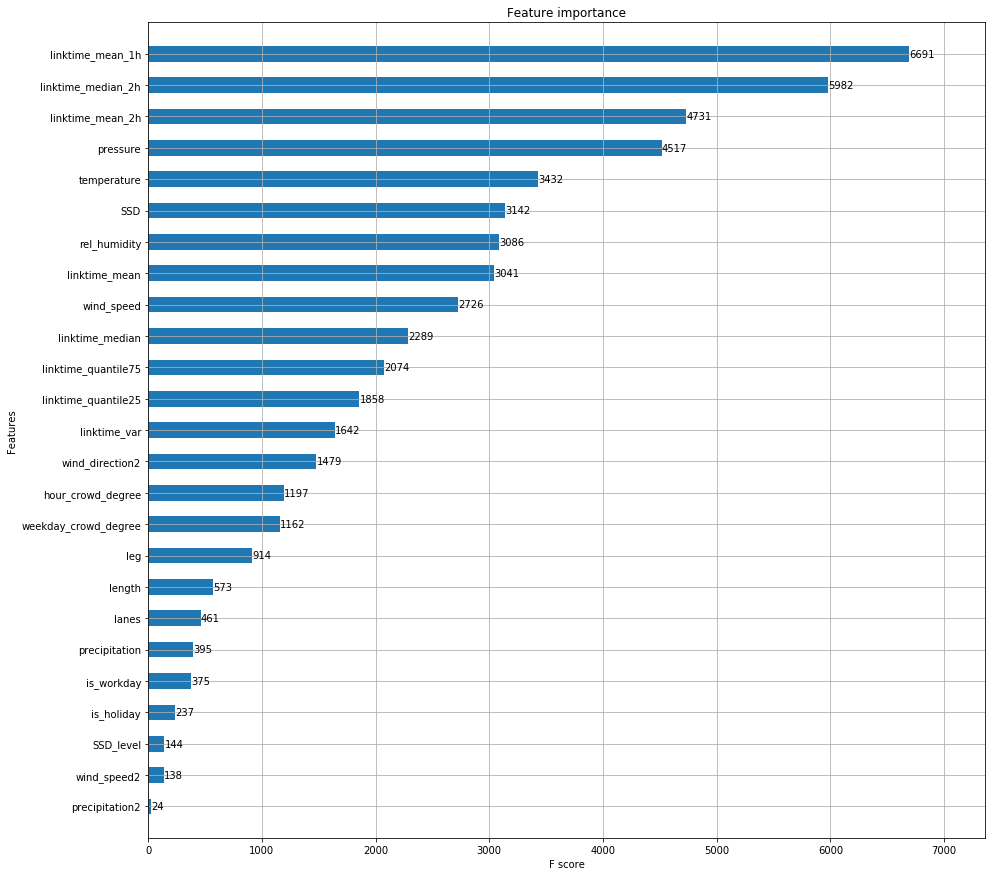

In [13]:
from xgboost import plot_importance
from matplotlib import pyplot

xlf.get_booster().feature_names = choice
xlf.get_booster().get_fscore()

fig,ax = pyplot.subplots(figsize=(15,15))
plot_importance(xlf,height=0.5,ax=ax)
pyplot.show()

In [28]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(weights="uniform")
knn.fit(x_train,y_train)
ans = knn.predict(x_test)
result=result.copy()
result['knn'] = pd.DataFrame(data=ans)
res2MAPE(result,'knn')

0.22700906872145063

In [31]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
ans = dt.predict(x_test)
result=result.copy()
result['dt'] = pd.DataFrame(data=ans)
res2MAPE(result,'dt')

0.3772748381858416

In [32]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(x_train,y_train)
ans = rfr.predict(x_test)
result=result.copy()
result['rfr'] = pd.DataFrame(data=ans)
res2MAPE(result,'rfr')

/Users/liyuan/anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.3023053754411095

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(x_train,y_train)
ans = gbr.predict(x_test)
result=result.copy()
result['gbr'] = pd.DataFrame(data=ans)
res2MAPE(result,'gbr')

0.26513905918968217

In [34]:
from sklearn import neural_network
# 不稳定
MLP = neural_network.MLPRegressor()
MLP.fit(x_train,y_train)
ans = MLP.predict(x_test)
result=result.copy()
result['MLP'] = pd.DataFrame(data=ans)
res2MAPE(result,'MLP')

0.21804017888203536

In [412]:
# 这里逐行打印出来 看了看
column_name = 'xgb'
ground_truth = pd.read_csv('phase1_training/20min_avg_travel_time_training_phase1.csv')
res_df = link2res(result,column_name)
#merge 3 keys
res_df['tollgate_id'] = res_df['tollgate_id'].astype(int)
ground_truth['tollgate_id'] = ground_truth['tollgate_id'].astype(int)
merged = pd.merge(merged,res_df,on= ['intersection_id','tollgate_id','time_window'],how='left')
#删除ground_truth都没有的行
merged = merged.dropna(axis=0,how='any')

KeyError: 'Column not found: xgb'

In [15]:
submistest

,link,start_time,y,is_workday,is_holiday,leg,linktime_mean_2h,linktime_median_2h,linktime_mean_1h,link_time,...,precipitation,wind_direction2,wind_speed2,precipitation2,SSD,SSD_level,length,lanes,weekday_crowd_degree,hour_crowd_degree
0,110,2016-10-18 06:00:00,0,1,0,66,11.615922,11.442000,12.066222,06:00:00,...,0.0,3,1,0,74.981803,1,109,3,0.134242,0.008052
1,123,2016-10-18 06:00:00,0,1,0,66,6.427040,6.582294,7.230196,06:00:00,...,0.0,3,1,0,74.981803,1,59,3,0.134242,0.008052
2,107,2016-10-18 06:00:00,0,1,0,66,3.965485,3.790382,4.439144,06:00:00,...,0.0,3,1,0,74.981803,1,34,3,0.134242,0.008052
3,108,2016-10-18 06:00:00,0,1,0,66,5.090299,4.723000,5.541111,06:00:00,...,0.0,3,1,0,74.981803,1,40,3,0.134242,0.008052
4,120,2016-10-18 06:00:00,0,1,0,66,0.820741,0.803056,0.775212,06:00:00,...,0.0,3,1,0,74.981803,1,6,1,0.134242,0.008052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,121,2016-10-24 18:40:00,0,1,0,5,24.100915,21.517000,18.828750,18:40:00,...,0.0,5,2,0,67.742836,0,118,1,0.129182,0.015984
4028,106,2016-10-24 18:40:00,0,1,0,5,1.404627,1.419167,1.378889,18:40:00,...,0.0,5,2,0,67.742836,0,15,1,0.129182,0.015984
4029,113,2016-10-24 18:40:00,0,1,0,5,19.435222,20.390000,18.074861,18:40:00,...,0.0,5,2,0,67.742836,0,144,2,0.129182,0.015984
4030,105,2016-10-24 18:40:00,0,1,0,5,12.047133,11.642222,14.864212,18:40:00,...,0.0,5,2,0,67.742836,0,78,2,0.129182,0.015984


In [14]:
def model2submission(model):
    ans = model.predict(x_submission)
    result=submistest[['link','start_time','y','linktime_mean']]
    result = result.copy()
    result['xlf'] = pd.DataFrame(data=ans)
    pred = link2res(result,'xlf')
    pred = pred.copy()
    pred['tollgate_id'] = pred['tollgate_id'].astype('int')
    
    submission = pd.read_csv('./submission_sample/submission_sample_travelTime.csv')
    result = pd.merge(submission,pred,on=['intersection_id','tollgate_id','time_window'],how='left')\
            .drop('avg_travel_time',axis=1)
    result.columns=submission.columns
    result.to_csv('./submission_sample/xgb_travelTime.csv', index=False)
    
model2submission(xlf)

ValueError: feature_names mismatch: ['is_workday', 'is_holiday', 'leg', 'linktime_mean_2h', 'linktime_median_2h', 'linktime_mean_1h', 'linktime_mean', 'linktime_median', 'linktime_var', 'linktime_quantile25', 'linktime_quantile75', 'pressure', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation', 'wind_direction2', 'wind_speed2', 'precipitation2', 'SSD', 'SSD_level', 'length', 'lanes', 'weekday_crowd_degree', 'hour_crowd_degree'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24']
expected weekday_crowd_degree, linktime_median, linktime_mean_2h, wind_speed, rel_humidity, temperature, wind_direction2, linktime_var, precipitation2, length, precipitation, SSD_level, is_workday, SSD, linktime_median_2h, leg, linktime_mean_1h, pressure, hour_crowd_degree, lanes, linktime_mean, linktime_quantile75, linktime_quantile25, is_holiday, wind_speed2 in input data
training data did not have the following fields: f7, f4, f10, f24, f19, f13, f9, f15, f3, f23, f2, f22, f6, f20, f12, f8, f0, f1, f21, f17, f18, f5, f11, f16, f14